# Recommender Systems with Movielens Data

## Splitting into Training and Testing Data

### Loading Data from Disk

In [1]:
import numpy as np
from scipy import sparse

In [2]:
def load():    
    data = np.loadtxt('data/ml-100k/u.data')
    ij = data[:, :2]
    ij -= 1
    values = data[:, 2]
    reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    return reviews.toarray()

In [3]:
reviews = load()
U,M = np.where(reviews)

In [4]:
import random
test_idxs = np.array(random.sample(range(len(U)), len(U)//10))

In [5]:
train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0

In [6]:
test = np.zeros_like(reviews)
test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]

In [7]:
class NormalizePositive(object):
    def __init__(self, axis=0):
        self.axis = axis
    
    def fit(self, features, y=None):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        count0 = binary.sum(axis=0)
        count0[count0 == 0] = 1
        self.mean = features.sum(axis=0)/count0
        diff = (features - self.mean) * binary
        diff **=2
        self.std = np.sqrt(0.1 + diff.sum(axis=0)/count0)
        return self
    
    def transform(self, features):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary
        if self.axis == 1:
            features = features.T
        return features
    
    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()
        if self.axis == 1:
            features = features.T
        features *= self.std
        features += self.mean
        if self.axis == 1:
            features = features.T
        return features
    
    def fit_transform(self, features):
        return self.fit(features).transform(features)

We want to visualize the data now. Each rating is depicted as a little square.

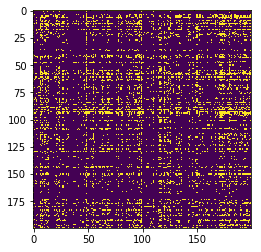

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
norm = NormalizePositive(axis=1)
binary = (train > 0)
train = norm.fit_transform(train)
plt.imshow(binary[:200, :200], interpolation='nearest')

### Using Neighborhood Approach

In [9]:
from scipy.spatial import distance
dists = distance.pdist(binary, 'correlation')
dists = distance.squareform(dists)

In [10]:
neighbors = dists.argsort(axis=1)

In [11]:
filled = train.copy()
for u in range(filled.shape[0]):
    n_u = neighbors[u, 1:]
for m in range(filled.shape[1]):
    revs = [train[neigh, m]
               for neigh in n_u
                   if binary [neigh, m]]
    if len(revs):
        n = len(revs)
        n //= 2
        n += 1
        revs = revs[:n]
        filled[u, m] = np.mean(revs)

In [12]:
predicted = norm.inverse_transform(filled)

In [13]:
from sklearn import metrics

In [16]:
reviews = reviews.T
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary neighbors): {:.1%}'.format(r2))

R2 score (binary neighbors): 13.4%


### Using Regression

In [20]:
from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(alphas=[0.0125, 0.025, 0.05, 0.125, 0.25, .5, 1., 2., 4.])

In [21]:
filled = train.copy()

In [ ]:
for u in range(train.shape[0]):
    curtrain = np.delete(train, u, axis=0)
    bu = binary[u]
    reg.fit(curtrain[:,bu].T, train[u, bu])
    filled[u, ~bu] = reg.predict(curtrain[:,~bu].T)